In [18]:
import segyio
import numpy as np
import matplotlib.pyplot as plt
import time

In [19]:
def segy_decomp(segy_file, plot_data = False, read_direc='xline', inp_res = np.float64):
    print('Starting SEG-Y decompressor')
    output = segyio.spec()

    with segyio.open(segy_file, "r" ) as segyfile:
        segyfile.mmap()

        # Store some initial object attributes
        output.inl_start = segyfile.ilines[0]
        output.inl_end = segyfile.ilines[-1]
        output.inl_step = segyfile.ilines[1] - segyfile.ilines[0]

        output.xl_start = segyfile.xlines[0]
        output.xl_end = segyfile.xlines[-1]
        output.xl_step = segyfile.xlines[1] - segyfile.xlines[0]

        output.t_start = int(segyfile.samples[0])
        output.t_end = int(segyfile.samples[-1])
        output.t_step = int(segyfile.samples[1] - segyfile.samples[0])

        # Pre-allocate a numpy array that holds the SEGY-cube
        output.data = np.empty((segyfile.xline.len,segyfile.iline.len,\
                        (output.t_end - output.t_start)//output.t_step+1), dtype = np.float32)

        # Read the entire cube line by line in the desired direction
        if read_direc == 'inline':           
            for il_index in range(segyfile.xline.len):
                output.data[il_index,:,:] = segyfile.iline[segyfile.ilines[il_index]]
        elif read_direc == 'xline':
            for xl_index in range(segyfile.iline.len):
                output.data[:,xl_index,:] = segyfile.xline[segyfile.xlines[xl_index]]

        elif read_direc == 'full':
            output.data = segyio.tools.cube(segy_file)
        else:
            print('Define reading direction(read_direc) using either ''inline'', ''xline'', or ''full''')


        # Convert the numpy array to span between -127 and 127 and convert to the desired format
        factor = 127/np.amax(np.absolute(output.data))
        if inp_res == np.float32:
            output.data = (output.data*factor)
        else:
            output.data = (output.data*factor).astype(dtype = inp_res)

        # If sepcified, plot a given x-line to test the read data
        if plot_data:
            data = output.data[:,100,:]
            plt.imshow(data.T,interpolation="nearest", cmap="gray")
            plt.colorbar()
            plt.show()
            
    # Return the output object
    print('Finished using the SEG-Y decompressor')
    return output

In [20]:
seis = segy_decomp('F3_entire.segy', plot_data = False, read_direc='inline', inp_res = np.float32)
data_3D = seis.data
print(data_3D.shape)

Starting SEG-Y decompressor
Finished using the SEG-Y decompressor
(651, 951, 462)


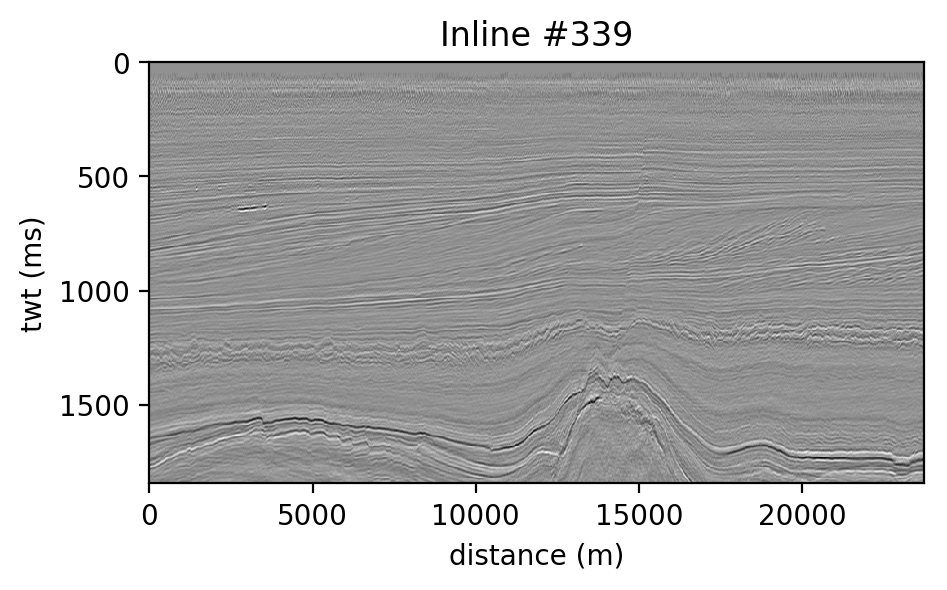

In [21]:
data = data_3D[239, :, :]

fig = plt.figure(figsize=(5,5), dpi=200)
plt.imshow(data.T,interpolation="nearest", cmap="gray", extent=(0, 23750, 1844, 0), aspect=7)
#plt.colorbar()
plt.xlabel('distance (m)')
plt.ylabel('twt (ms)')
plt.title('Inline #339')
plt.show()

In [22]:
file_list = ['multi_else_ilxl.pts','multi_grizzly_ilxl.pts','multi_high_amp_continuous_ilxl.pts','multi_high_amplitude_ilxl.pts','multi_low_amp_dips_ilxl.pts','multi_low_amplitude_ilxl.pts','multi_low_coherency_ilxl.pts','multi_salt_ilxl.pts','multi_steep_dips_ilxl.pts']
adr_list = np.empty([0,4], dtype = np.int32)

# Iterate through the list of example adresses and store the class as an integer
for i in range(len(file_list)):
    a = np.loadtxt(file_list[i], skiprows=0, usecols = range(3), dtype = np.int32)
    adr_list = np.append(adr_list,np.append(a,i*np.ones((len(a),1),dtype = np.int32),axis=1),axis=0)
print(adr_list.shape)

(141111, 4)


In [23]:
labels = -1*np.ones_like(seis.data[239, :, :], dtype = int)
print(labels.shape)
for i in range(adr_list.shape[0]):
    z_idx = int(adr_list[i, 2]//4) - 1
    labels[adr_list[i, 1]-300, z_idx] = adr_list[i, 3]

(951, 462)


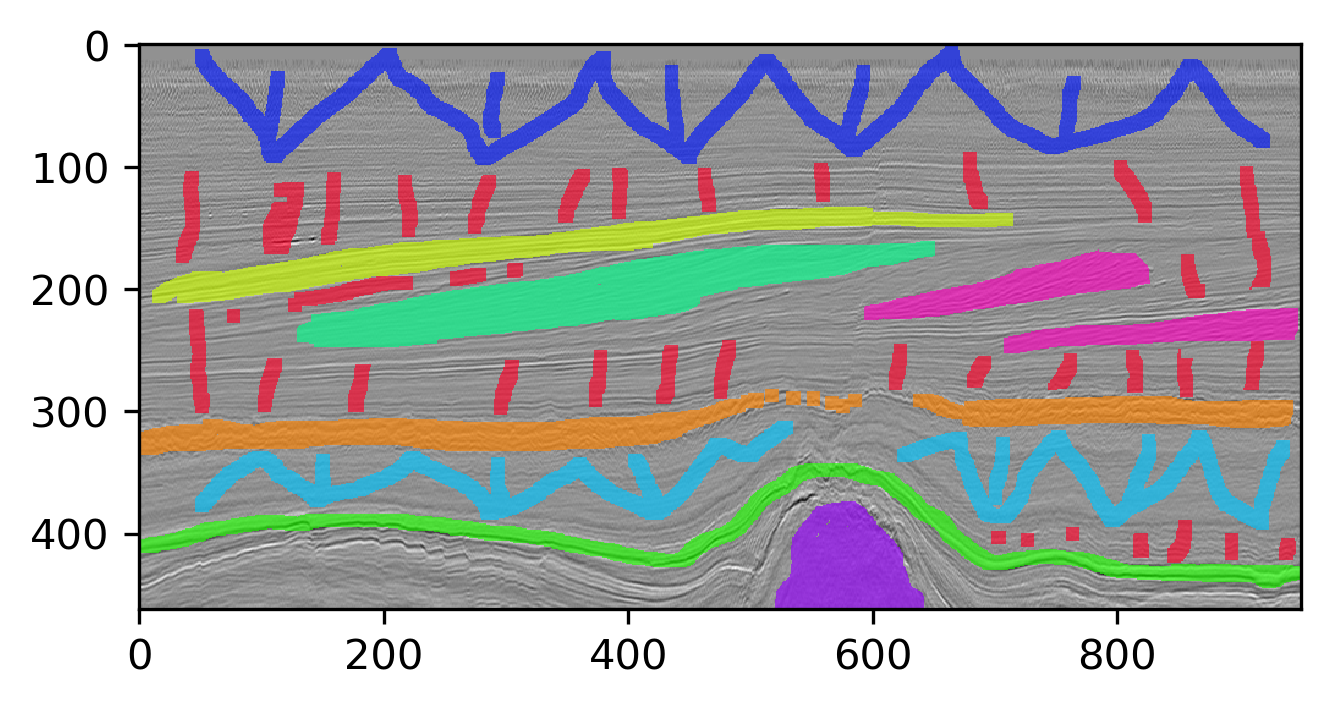

In [24]:
masked = np.ma.masked_where(labels == -1, labels)

fig = plt.figure(figsize=(5,3), dpi=300)
plt.imshow(data.T,interpolation="nearest", cmap="gray")
plt.imshow(masked.T,interpolation="nearest", cmap="gist_rainbow", alpha = 0.65)
plt.show()

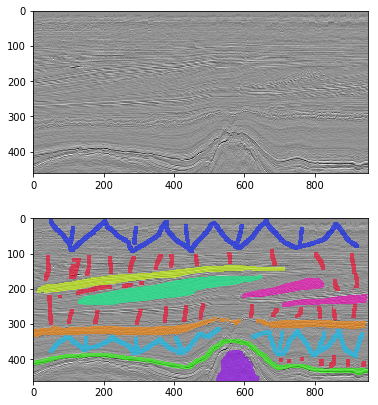

In [8]:
fig = plt.figure(1, figsize=(6,7))
plt.subplot(211)
plt.imshow(data.T,interpolation="nearest", cmap="gray")

plt.subplot(212)
plt.imshow(data.T,interpolation="nearest", cmap="gray")
plt.imshow(masked.T,interpolation="nearest", cmap="gist_rainbow", alpha = 0.6)
plt.show()
fig.savefig('labels.png', dpi=300)